In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import logging

# 禁用matplotlib字体管理器的警告
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# 设置中文字体
ukai_font = fm.FontProperties(fname='/usr/share/fonts/truetype/arphic/ukai.ttc')

# 显示文件信息
file_path = 'sde_data_cuda.npy'
file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
print(f"文件大小: {file_size_mb:.2f} MB")

# 读取数据
data = np.load(file_path)
N = data.shape[0]

# 显示数据详情
print(f"数据形状: {data.shape}")
print(f"数据类型: {data.dtype}")
print(f"数据总数: {data.size}")
print(f"维度数量: {data.ndim}")

# 显示数据统计信息
print("\n数据统计信息:")
print(f"最小值: {data.min(axis=0)}")
print(f"最大值: {data.max(axis=0)}")
print(f"均值: {data.mean(axis=0)}")
print(f"标准差: {data.std(axis=0)}")



mask_x1 = (data[:, 0] >= -4) & (data[:, 0] <= 4) 
mask_x2 = (data[:, 1] >= -6) & (data[:, 1] <= 6)
mask = mask_x1 & mask_x2
data = data[mask]
print('============================')
# 显示数据统计信息
print("\n数据统计信息:")
print(f"最小值: {data.min(axis=0)}")
print(f"最大值: {data.max(axis=0)}")
print(f"均值: {data.mean(axis=0)}")
print(f"标准差: {data.std(axis=0)}")

print(f"Number of points in Omega: {len(data)} ({len(data)/N*100:.2f}%)")


FileNotFoundError: [Errno 2] No such file or directory: 'sde_data_cuda.npy'

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# 设置随机种子以确保可复现性
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. 数据生成函数 - 使用EM方案生成时间序列
def phi(x1, x2):
    """计算phi(x1, x2) = 1 + (2/15)(4x1^2 - x1*x2 + x2^2)"""
    return 1 + (2/15) * (4*x1**2 - x1*x2 + x2**2)

def drift(x):
    """漂移项 a(x)"""
    x1, x2 = x[:, 0], x[:, 1]
    a1 = -1.5*x1 + x2
    a2 = 0.25*x1 - 1.5*x2
    return torch.stack([a1, a2], dim=1)





# 2. 定义神经网络模型
class Mish(nn.Module):
    """Mish激活函数: x * tanh(softplus(x))"""
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x * torch.tanh(torch.nn.functional.softplus(x))
        # return x * torch.tanh(torch.log(1 + torch.exp(x)))

class ReLU3(nn.Module):
    """ReLU3激活函数: min(max(0,x), 3)"""
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return torch.clamp(torch.relu(x), max=3.0)

class ResNetBlock(nn.Module):
    """残差网络块"""
    def __init__(self, dim, width, activation='mish'):
        super(ResNetBlock, self).__init__()
        self.lin1 = nn.Linear(dim, width)
        self.lin2 = nn.Linear(width, dim)
        
        # 选择激活函数
        if activation == 'relu':
            self.act = nn.ReLU()
        elif activation == 'mish':
            self.act = Mish()
        elif activation == 'relu3':
            self.act = ReLU3()
        else:
            raise ValueError(f"不支持的激活函数: {activation}")

        # Kaiming 初始化
        nn.init.kaiming_normal_(self.lin1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.lin2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.zeros_(self.lin1.bias)
        nn.init.zeros_(self.lin2.bias)
    
    def forward(self, x):
        return x + self.lin2(self.act(self.lin1(x)))

class ResNet(nn.Module):
    """残差网络"""
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=6, activation='mish'):
        super(ResNet, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        
        # 选择激活函数
        if activation == 'relu':
            self.act = nn.ReLU()
        elif activation == 'mish':
            self.act = Mish()
        elif activation == 'relu3':
            self.act = ReLU3()
        else:
            raise ValueError(f"不支持的激活函数: {activation}")
        
        self.blocks = nn.ModuleList([
            ResNetBlock(hidden_dim, hidden_dim, activation) for _ in range(num_blocks)
        ])
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.act(self.input_layer(x))
        
        for block in self.blocks:
            x = block(x)
        
        return self.output_layer(x)

class DriftNet(nn.Module):
    """估计漂移项的网络 - 使用ReLU激活函数"""
    def __init__(self, input_dim=2, hidden_dim=50, output_dim=2, num_blocks=6):
        super(DriftNet, self).__init__()
        self.net = ResNet(input_dim, hidden_dim, output_dim, num_blocks, activation='relu')
    
    def forward(self, x):
        return self.net(x)



# 3. 训练函数

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_drift_net_from_data(a_nn, train_data, dt=0.05, num_iterations=20000, batch_size=10000, lr=1e-4, omega_bounds=([-4, 4], [-6, 6])):
    """训练漂移项网络 - 使用时间序列数据中的实际位移"""
    print("Training drift network from time series data...")
    a_nn.to(device)
    optimizer = optim.Adam(a_nn.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_iterations)
    
    losses = []
    
    # 准备数据：计算位移 y = (x_{n+1} - x_n)/dt
    N = len(train_data)
    y_data = np.zeros((N-1, train_data.shape[1]))  # 初始化位移数组
    for n in range(N-1):
        y_data[n] = (train_data[n+1] - train_data[n]) / dt
    
    mask_x1 = (train_data[:, 0] >= -4) & (train_data[:, 0] <= 4) 
    mask_x2 = (train_data[:, 1] >= -6) & (train_data[:, 1] <= 6)
    mask = mask_x1 & mask_x2
    train_data = train_data[mask]

    # 对应的x点取前N-1个点
    x_data = train_data[:-1]
    
    for i in tqdm(range(num_iterations)):
        # 随机抽取批次
        idx = np.random.choice(len(x_data), batch_size)
        x_batch = torch.tensor(x_data[idx], dtype=torch.float32, device=device)
        y_batch = torch.tensor(y_data[idx], dtype=torch.float64, device=device)
        
        # 前向传播
        a_pred = a_nn(x_batch)
        
        # 计算损失：直接计算所有维度的 MSE
        loss = torch.mean((a_pred - y_batch) ** 2)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(a_nn.parameters(), max_norm=10.0)      # 梯度裁剪
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        
        if (i+1) % 1000 == 0:
            print(f"Iteration {i+1}/{num_iterations}, Loss: {loss.item():.6f}")
    
    return losses

def generate_grid_points(nx=300, ny=300):
    """生成评估网格点"""
    x = np.linspace(-4, 4, nx)
    y = np.linspace(-6, 6, ny)
    X, Y = np.meshgrid(x, y)
    
    # 将网格点展平为坐标点列表
    points = np.column_stack([X.ravel(), Y.ravel()])
    return points, X, Y

def compute_relative_L2_error(func_true, func_pred, grid_points):
    """计算相对L2误差"""
    true_vals = func_true(grid_points)
    pred_vals = func_pred(grid_points)
    
    error = np.sqrt(np.mean((true_vals - pred_vals)**2))
    norm = np.sqrt(np.mean(true_vals**2))
    
    return error / norm

# 4. 评估函数
def evaluate_drift_net(a_nn, grid_points, X, Y):
    """评估漂移项网络"""
    # 转换为张量
    x_tensor = torch.tensor(grid_points, dtype=torch.float64, device=device)
    
    # 计算真实值和预测值
    with torch.no_grad():
        a_true = drift(x_tensor).cpu().numpy()
        a_pred = a_nn(x_tensor).cpu().numpy()
    
    # 计算相对L2误差
    error_a1 = np.sqrt(np.mean((a_true[:, 0] - a_pred[:, 0])**2)) / np.sqrt(np.mean(a_true[:, 0]**2))
    error_a2 = np.sqrt(np.mean((a_true[:, 1] - a_pred[:, 1])**2)) / np.sqrt(np.mean(a_true[:, 1]**2))
    total_error = np.sqrt(np.mean(np.sum((a_true - a_pred)**2, axis=1))) / np.sqrt(np.mean(np.sum(a_true**2, axis=1)))
    
    print(f"Drift relative L2 errors - a1: {error_a1:.4e}, a2: {error_a2:.4e}, total: {total_error:.4e}")
    
    # 绘制结果
    plt.figure(figsize=(18, 6))
    
    # 第一个分量
    plt.subplot(131)
    plt.contourf(X, Y, a_true[:, 0].reshape(X.shape), 50, cmap='viridis')
    plt.colorbar(label='True a1')
    plt.title('True Drift a1')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.subplot(132)
    plt.contourf(X, Y, a_pred[:, 0].reshape(X.shape), 50, cmap='viridis')
    plt.colorbar(label='Predicted a1')
    plt.title('Predicted Drift a1')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.subplot(133)
    plt.contourf(X, Y, (a_true[:, 0] - a_pred[:, 0]).reshape(X.shape), 50, cmap='coolwarm')
    plt.colorbar(label='Error a1')
    plt.title(f'Error in Drift a1 (L2 rel. error: {error_a1:.4e})')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.tight_layout()
    plt.savefig('results/drift_a1_comparison.png')
    plt.close()
    
    # 第二个分量
    plt.figure(figsize=(18, 6))
    
    plt.subplot(131)
    plt.contourf(X, Y, a_true[:, 1].reshape(X.shape), 50, cmap='viridis')
    plt.colorbar(label='True a2')
    plt.title('True Drift a2')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.subplot(132)
    plt.contourf(X, Y, a_pred[:, 1].reshape(X.shape), 50, cmap='viridis')
    plt.colorbar(label='Predicted a2')
    plt.title('Predicted Drift a2')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.subplot(133)
    plt.contourf(X, Y, (a_true[:, 1] - a_pred[:, 1]).reshape(X.shape), 50, cmap='coolwarm')
    plt.colorbar(label='Error a2')
    plt.title(f'Error in Drift a2 (L2 rel. error: {error_a2:.4e})')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.tight_layout()
    plt.savefig('results/drift_a2_comparison.png')
    plt.close()
    
    return total_error


# 5. 主函数
def main():
    # 创建输出目录
    os.makedirs("results", exist_ok=True)
    
    # 参数设置
    dt = 0.05  # 时间步长
    N = 2*10**7  # 数据点数 (实际实现中可能需要减少点数以加快运算)
    hidden_dim = 50  # 隐藏层维度
    num_blocks = 6   # 残差网络块数量
    
    # 训练参数
    num_iterations = 20000  # 训练迭代次数
    batch_size = 10000      # 批处理大小
    learning_rate = 1e-4   # 学习率
    
    # 1. 数据准备
    data_file = "sde_data_cuda.npy"

    print(f"Loading data from {data_file}...")
    data = np.load(data_file)
    print(f"Loaded {len(data)} data points")

    
    # 2. 准备评估网格
    grid_points, X, Y = generate_grid_points(nx=100, ny=100)
    
    # 3. 初始化模型
    print("Initializing models...")
    drift_net = DriftNet(input_dim=2, hidden_dim=hidden_dim, output_dim=2, num_blocks=num_blocks).to(device)
    # diffusion_net = DiffusionNet(input_dim=2, hidden_dim=hidden_dim, output_dim=3, num_blocks=num_blocks).to(device)
    # density_net = DensityNet(input_dim=2, hidden_dim=hidden_dim, output_dim=1, num_blocks=num_blocks).to(device)
    
    # 4. 训练和评估模型
    # 4.1 训练漂移项网络
    drift_losses = train_drift_net_from_data(
        drift_net, 
        data, 
        dt=dt, 
        num_iterations=num_iterations, 
        batch_size=batch_size, 
        lr=learning_rate
    )
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(drift_losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Drift Network Training Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.savefig('results/drift_training_loss.png')
    plt.close()
    
    # 评估漂移项网络
    drift_error = evaluate_drift_net(drift_net, grid_points, X, Y)
    print(f"Total drift network error: {drift_error:.6f}")


# 执行主函数
if __name__ == "__main__":
    main()

Using device: cuda
Loading data from sde_data_cuda.npy...
Loaded 20000000 data points
Initializing models...
Training drift network from time series data...


  5%|▌         | 1016/20000 [00:11<03:40, 86.25it/s]

Iteration 1000/20000, Loss: 1675.458008


 10%|█         | 2011/20000 [00:22<03:19, 89.99it/s]

Iteration 2000/20000, Loss: 1748.650391


 15%|█▌        | 3016/20000 [00:34<03:11, 88.73it/s]

Iteration 3000/20000, Loss: 1714.260742


 20%|██        | 4010/20000 [00:45<02:51, 93.19it/s] 

Iteration 4000/20000, Loss: 1671.008301


 25%|██▌       | 5017/20000 [00:56<02:47, 89.18it/s] 

Iteration 5000/20000, Loss: 1666.587402


 30%|███       | 6009/20000 [01:09<03:01, 77.23it/s]

Iteration 6000/20000, Loss: 1745.371582


 35%|███▌      | 7009/20000 [01:22<02:47, 77.38it/s]

Iteration 7000/20000, Loss: 1608.739380


 40%|████      | 8011/20000 [01:34<02:15, 88.27it/s]

Iteration 8000/20000, Loss: 1700.186768


 45%|████▌     | 9015/20000 [01:46<02:03, 89.19it/s]

Iteration 9000/20000, Loss: 1721.941528


 50%|█████     | 10010/20000 [01:57<01:53, 87.63it/s]

Iteration 10000/20000, Loss: 1657.847412


 55%|█████▌    | 11013/20000 [02:08<01:41, 88.33it/s] 

Iteration 11000/20000, Loss: 1745.169922


 60%|██████    | 12011/20000 [02:19<01:29, 88.83it/s]

Iteration 12000/20000, Loss: 1666.066406


 65%|██████▌   | 13015/20000 [02:31<01:26, 80.54it/s]

Iteration 13000/20000, Loss: 1714.924561


 70%|███████   | 14015/20000 [02:43<01:16, 78.61it/s] 

Iteration 14000/20000, Loss: 1699.047729


 75%|███████▌  | 15016/20000 [02:54<00:53, 92.57it/s] 

Iteration 15000/20000, Loss: 1671.987915


 80%|████████  | 16011/20000 [03:05<00:44, 90.34it/s]

Iteration 16000/20000, Loss: 1672.401611


 85%|████████▌ | 17017/20000 [03:17<00:30, 98.38it/s] 

Iteration 17000/20000, Loss: 1639.760010


 90%|█████████ | 18015/20000 [03:28<00:22, 89.48it/s] 

Iteration 18000/20000, Loss: 1738.780518


 95%|█████████▌| 19011/20000 [03:39<00:11, 88.06it/s]

Iteration 19000/20000, Loss: 1593.578125


100%|██████████| 20000/20000 [03:50<00:00, 86.61it/s] 


Iteration 20000/20000, Loss: 1649.545776
Drift relative L2 errors - a1: 9.7590e-01, a2: 1.0064e+00, total: 9.9224e-01
Total drift network error: 0.992241


# 1.模型与设置

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# 设置随机种子以确保可复现性
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def drift(x):
    """漂移项 a(x)"""
    x1, x2 = x[:, 0], x[:, 1]
    a1 = -1.5*x1 + x2
    a2 = 0.25*x1 - 1.5*x2
    return torch.stack([a1, a2], dim=1)

# 2. 定义神经网络模型
class Mish(nn.Module):
    """Mish激活函数: x * tanh(softplus(x))"""
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x * torch.tanh(torch.nn.functional.softplus(x))
        # return x * torch.tanh(torch.log(1 + torch.exp(x)))

class ReLU3(nn.Module):
    """ReLU3激活函数: min(max(0,x), 3)"""
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return torch.clamp(torch.relu(x), max=3.0)

class ResNetBlock(nn.Module):
    """残差网络块"""
    def __init__(self, dim, width, activation='mish'):
        super(ResNetBlock, self).__init__()
        self.lin1 = nn.Linear(dim, width)
        self.lin2 = nn.Linear(width, dim)
        
        # 选择激活函数
        if activation == 'relu':
            self.act = nn.ReLU()
        elif activation == 'mish':
            self.act = Mish()
        elif activation == 'relu3':
            self.act = ReLU3()
        else:
            raise ValueError(f"不支持的激活函数: {activation}")

        # Kaiming 初始化
        nn.init.kaiming_normal_(self.lin1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.lin2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.zeros_(self.lin1.bias)
        nn.init.zeros_(self.lin2.bias)
    
    def forward(self, x):
        return x + self.lin2(self.act(self.lin1(x)))

class ResNet(nn.Module):
    """残差网络"""
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=6, activation='mish'):
        super(ResNet, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        
        # 选择激活函数
        if activation == 'relu':
            self.act = nn.ReLU()
        elif activation == 'mish':
            self.act = Mish()
        elif activation == 'relu3':
            self.act = ReLU3()
        else:
            raise ValueError(f"不支持的激活函数: {activation}")
        
        self.blocks = nn.ModuleList([
            ResNetBlock(hidden_dim, hidden_dim, activation) for _ in range(num_blocks)
        ])
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.act(self.input_layer(x))
        
        for block in self.blocks:
            x = block(x)
        
        return self.output_layer(x)

class DriftNet(nn.Module):
    """估计漂移项的网络 - 使用ReLU激活函数"""
    def __init__(self, input_dim=2, hidden_dim=50, output_dim=2, num_blocks=6):
        super(DriftNet, self).__init__()
        self.net = ResNet(input_dim, hidden_dim, output_dim, num_blocks, activation='relu')
    
    def forward(self, x):
        return self.net(x)

# 3. 训练函数

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_grid_points(nx=300, ny=300, for_eval=False):
    """生成评估网格点
    
    参数:
        nx, ny: 网格点数量
        for_eval: 如果为True，则生成10,000个点（用于计算相对L2误差）
    """
    if for_eval:
        # 为了计算相对L2误差，生成10,000个高斯求积点
        # 这里简单地生成均匀网格点，实际上应该使用高斯求积点
        num_points = 10000
        x_points = np.random.uniform(-4, 4, num_points)
        y_points = np.random.uniform(-6, 6, num_points)
        points = np.column_stack([x_points, y_points])
        return points, None, None
    else:
        # 为可视化生成网格点
        x = np.linspace(-4, 4, nx)
        y = np.linspace(-6, 6, ny)
        X, Y = np.meshgrid(x, y)
        
        # 将网格点展平为坐标点列表
        points = np.column_stack([X.ravel(), Y.ravel()])
        return points, X, Y

def compute_relative_L2_error(func_true, func_pred, grid_points):
    """计算相对L2误差，使用10,000个高斯求积点"""
    true_vals = func_true(grid_points)
    pred_vals = func_pred(grid_points)
    
    error = np.sqrt(np.mean((true_vals - pred_vals)**2))
    norm = np.sqrt(np.mean(true_vals**2))
    
    return error / norm

# 4. 评估函数
def evaluate_drift_net(a_nn, grid_points, X, Y):
    """评估漂移项网络"""
    # 生成用于计算相对L2误差的10,000个高斯求积点
    eval_points, _, _ = generate_grid_points(for_eval=True)
    
    # 转换为张量
    x_tensor = torch.tensor(grid_points, dtype=torch.float64, device=device)
    eval_tensor = torch.tensor(eval_points, dtype=torch.float64, device=device)
    
    # 计算真实值和预测值（用于可视化）
    with torch.no_grad():
        a_true = drift(x_tensor).cpu().numpy()
        a_pred = a_nn(x_tensor).cpu().numpy()
        
        # 计算用于误差的真实值和预测值
        a_true_eval = drift(eval_tensor).cpu().numpy()
        a_pred_eval = a_nn(eval_tensor).cpu().numpy()
    
    # 计算相对L2误差
    error_a1 = np.sqrt(np.mean((a_true_eval[:, 0] - a_pred_eval[:, 0])**2)) / np.sqrt(np.mean(a_true_eval[:, 0]**2))
    error_a2 = np.sqrt(np.mean((a_true_eval[:, 1] - a_pred_eval[:, 1])**2)) / np.sqrt(np.mean(a_true_eval[:, 1]**2))
    total_error = np.sqrt(np.mean(np.sum((a_true_eval - a_pred_eval)**2, axis=1))) / np.sqrt(np.mean(np.sum(a_true_eval**2, axis=1)))
    
    print(f"Drift relative L2 errors - a1: {error_a1:.4e}, a2: {error_a2:.4e}, total: {total_error:.4e}")
    
    # 绘制结果
    plt.figure(figsize=(18, 6))
    
    # 第一个分量
    plt.subplot(131)
    plt.contourf(X, Y, a_true[:, 0].reshape(X.shape), 50, cmap='viridis')
    plt.colorbar(label='True a1')
    plt.title('True Drift a1')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.subplot(132)
    plt.contourf(X, Y, a_pred[:, 0].reshape(X.shape), 50, cmap='viridis')
    plt.colorbar(label='Predicted a1')
    plt.title('Predicted Drift a1')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.subplot(133)
    plt.contourf(X, Y, (a_true[:, 0] - a_pred[:, 0]).reshape(X.shape), 50, cmap='coolwarm')
    plt.colorbar(label='Error a1')
    plt.title(f'Error in Drift a1 (L2 rel. error: {error_a1:.4e})')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.tight_layout()
    plt.savefig('results/drift_a1_comparison.png')
    plt.close()
    
    # 第二个分量
    plt.figure(figsize=(18, 6))
    
    plt.subplot(131)
    plt.contourf(X, Y, a_true[:, 1].reshape(X.shape), 50, cmap='viridis')
    plt.colorbar(label='True a2')
    plt.title('True Drift a2')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.subplot(132)
    plt.contourf(X, Y, a_pred[:, 1].reshape(X.shape), 50, cmap='viridis')
    plt.colorbar(label='Predicted a2')
    plt.title('Predicted Drift a2')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.subplot(133)
    plt.contourf(X, Y, (a_true[:, 1] - a_pred[:, 1]).reshape(X.shape), 50, cmap='coolwarm')
    plt.colorbar(label='Error a2')
    plt.title(f'Error in Drift a2 (L2 rel. error: {error_a2:.4e})')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.tight_layout()
    plt.savefig('results/drift_a2_comparison.png')
    plt.close()
    
    return total_error


Using device: cuda


# 2.训练

In [8]:


def train_drift_net_from_data(a_nn, train_data, dt=0.05, num_iterations=20000, batch_size=10000, lr=1e-4, omega_bounds=([-4, 4], [-6, 6])):
    """训练漂移项网络 - 使用时间序列数据中的实际位移"""
    print("训练漂移项网络...")
    a_nn.to(device)
    optimizer = optim.Adam(a_nn.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_iterations)
    
    losses = []
    
    # 首先筛选 Omega 内的点
    mask_x1 = (train_data[:, 0] >= omega_bounds[0][0]) & (train_data[:, 0] <= omega_bounds[0][1]) 
    mask_x2 = (train_data[:, 1] >= omega_bounds[1][0]) & (train_data[:, 1] <= omega_bounds[1][1])
    mask = mask_x1 & mask_x2
    filtered_data = train_data[mask]
    
    # 显示数据统计信息
    print("\n筛选后的数据统计信息:")
    print(f"数据点数量: {filtered_data.shape[0]} ({filtered_data.shape[0]/len(train_data)*100:.2f}%)")
    print(f"最小值: {filtered_data.min(axis=0)}")
    print(f"最大值: {filtered_data.max(axis=0)}")
    print(f"均值: {filtered_data.mean(axis=0)}")
    print(f"标准差: {filtered_data.std(axis=0)}")

    # 准备输入和目标数据
    N = len(filtered_data)
    x_data = filtered_data[:-1]  # 取前N-1个点作为输入
    
    # 计算位移 y = (x_{n+1} - x_n)/dt
    y_data = np.zeros((N-1, filtered_data.shape[1]))
    for n in range(N-1):
        y_data[n] = (filtered_data[n+1] - filtered_data[n]) / dt
    
    print(f"训练数据准备完成: x_data: {x_data.shape}, y_data: {y_data.shape}")
    
    # 检查 y_data 的数值范围
    print(f"位移数据统计: min={y_data.min(axis=0)}, max={y_data.max(axis=0)}, mean={y_data.mean(axis=0)}, std={y_data.std(axis=0)}")
    
    for i in tqdm(range(num_iterations)):
        # 随机抽取批次
        idx = np.random.choice(len(x_data), batch_size)
        x_batch = torch.tensor(x_data[idx], dtype=torch.float64, device=device)
        y_batch = torch.tensor(y_data[idx], dtype=torch.float64, device=device)
        
        # 前向传播
        a_pred = a_nn(x_batch)
        
        # 计算损失：直接计算所有维度的 MSE
        loss = torch.mean((a_pred - y_batch) ** 2)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        
        if (i+1) % 1000 == 0:
            print(f"迭代 {i+1}/{num_iterations}, 损失: {loss.item():.6f}")
    
    return losses


# 3. 主函数

In [9]:

# 5. 主函数
def main():
    print("\n" + "="*50)
    print("复现论文中的Student's t-distribution实验")
    print("="*50 + "\n")
    
    # 创建输出目录
    os.makedirs("results", exist_ok=True)
    
    # 参数设置 - 按照论文要求
    dt = 0.05  # 时间步长
    N = 2*10**7  # 数据点数
    hidden_dim = 50  # 隐藏层维度
    num_blocks = 6   # 残差网络块数量（6层隐藏层）
    
    # 训练参数 - 根据论文设置
    num_iterations = 20000  # 训练迭代次数
    drift_batch_size = 10000      # 漂移项批处理大小

    
    # 学习率 - 根据论文设置
    drift_lr = 1e-4        # 漂移项学习率

    
    # 1. 数据准备
    data_file = "sde_data_cuda.npy"
    if os.path.exists(data_file):
        print(f"加载已有数据: {data_file}...")
        data = np.load(data_file)
        # 如果需要，可以随机采样减少数据量
        if len(data) > N:
            indices = np.random.choice(len(data), N, replace=False)
            data = data[indices]
        print(f"加载了 {len(data)} 个数据点")
    else:
        print("生成新数据...")
        data = generate_data(dt=dt, N=N)
        np.save(data_file, data)
    
    # 2. 准备评估网格
    print("生成评估网格...")
    # 可视化用的网格 (100x100)
    vis_grid_points, X, Y = generate_grid_points(nx=100, ny=100)
    # 评估误差用的网格 (10,000高斯求积点)
    eval_grid_points, _, _ = generate_grid_points(for_eval=True)
    
    # 3. 初始化模型
    print("初始化神经网络模型...")
    drift_net = DriftNet(input_dim=2, hidden_dim=hidden_dim, output_dim=2, num_blocks=num_blocks).to(device)
    
    # 4. 训练和评估模型
    # 4.1 训练漂移项网络
    print("\n" + "-"*30)
    print("第一步: 训练漂移项网络")
    print("-"*30)
    drift_losses = train_drift_net_from_data(
        drift_net, 
        data, 
        dt=dt, 
        num_iterations=num_iterations, 
        batch_size=drift_batch_size, 
        lr=drift_lr
    )
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(drift_losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Drift Network Training Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.savefig('results/drift_training_loss.png')
    plt.close()
    
    # 评估漂移项网络
    print("\n评估漂移项网络...")
    drift_error = evaluate_drift_net(drift_net, vis_grid_points, X, Y)
    print(f"漂移项网络相对L2误差: {drift_error:.4e}")


# 执行主函数
if __name__ == "__main__":
    main()


复现论文中的Student's t-distribution实验

加载已有数据: sde_data_cuda.npy...
加载了 20000000 个数据点
生成评估网格...
初始化神经网络模型...

------------------------------
第一步: 训练漂移项网络
------------------------------
训练漂移项网络...

筛选后的数据统计信息:
数据点数量: 19734518 (98.67%)
最小值: [-3.9999886 -5.9999766]
最大值: [3.9999998 5.999994 ]
均值: [0.00100681 0.00066653]
标准差: [0.98415375 1.4839878 ]
训练数据准备完成: x_data: (19734517, 2), y_data: (19734517, 2)
位移数据统计: min=[-159.50411987 -237.2303009 ], max=[158.23001099 235.92623901], mean=[1.94006316e-08 5.45391047e-07], std=[28.46923542 42.96396005]


  5%|▌         | 1011/20000 [00:11<04:03, 77.96it/s]

迭代 1000/20000, 损失: 663.164307


 10%|█         | 2010/20000 [00:23<03:22, 88.96it/s] 

迭代 2000/20000, 损失: 661.026184


 15%|█▌        | 3009/20000 [00:34<03:11, 88.52it/s] 

迭代 3000/20000, 损失: 639.852112


 20%|██        | 4016/20000 [00:45<02:58, 89.53it/s]

迭代 4000/20000, 损失: 652.023071


 25%|██▌       | 5015/20000 [00:57<02:46, 90.22it/s]

迭代 5000/20000, 损失: 646.022034


 30%|███       | 6016/20000 [01:08<02:39, 87.57it/s]

迭代 6000/20000, 损失: 680.613953


 35%|███▌      | 7011/20000 [01:19<02:25, 89.17it/s]

迭代 7000/20000, 损失: 665.172058


 40%|████      | 8017/20000 [01:30<02:11, 91.31it/s]

迭代 8000/20000, 损失: 651.412537


 45%|████▌     | 9014/20000 [01:42<02:09, 84.88it/s] 

迭代 9000/20000, 损失: 664.242676


 50%|█████     | 10014/20000 [01:53<01:52, 88.70it/s]

迭代 10000/20000, 损失: 658.221008


 55%|█████▌    | 11016/20000 [02:04<01:40, 89.55it/s]

迭代 11000/20000, 损失: 678.550842


 60%|██████    | 12014/20000 [02:15<01:29, 89.07it/s] 

迭代 12000/20000, 损失: 672.192566


 65%|██████▌   | 13017/20000 [02:26<01:16, 91.52it/s] 

迭代 13000/20000, 损失: 653.649475


 70%|███████   | 14013/20000 [02:37<01:07, 88.21it/s]

迭代 14000/20000, 损失: 661.315002


 75%|███████▌  | 15014/20000 [02:49<00:56, 87.90it/s]

迭代 15000/20000, 损失: 673.820557


 80%|████████  | 16015/20000 [03:00<00:44, 88.74it/s]

迭代 16000/20000, 损失: 671.298035


 85%|████████▌ | 17013/20000 [03:11<00:33, 89.06it/s]

迭代 17000/20000, 损失: 661.399597


 90%|█████████ | 18014/20000 [03:23<00:21, 91.28it/s]

迭代 18000/20000, 损失: 653.968506


 95%|█████████▌| 19010/20000 [03:34<00:11, 88.70it/s] 

迭代 19000/20000, 损失: 654.255554


100%|██████████| 20000/20000 [03:45<00:00, 88.85it/s]


迭代 20000/20000, 损失: 669.372803

评估漂移项网络...
Drift relative L2 errors - a1: 8.6429e+00, a2: 1.2258e+01, total: 1.0724e+01
漂移项网络相对L2误差: 1.0724e+01


## 不使用归一化


复现论文中的Student's t-distribution实验

生成数据...


100%|██████████| 2000/2000 [00:01<00:00, 1313.16it/s]


筛选和预处理数据...
筛选后的数据点数量: 19612788
使用CUDA计算位移...
筛选后数据点数量: 19612787 (98.06%)
筛选后数据统计: min=[-3.99998713 -5.99999762], max=[3.99998236 6.        ], mean=[0.00132362 0.00100742], std=[0.93622767 1.77662503]
位移数据统计: min=[-156.29136086 -237.87876129], max=[156.66319847 237.86113739], mean=[-3.36408980e-07 -1.50931796e-06], std=[26.48424783 50.26428244]
生成网格点用于可视化和评估...

------------------------------
第一步: 训练漂移项网络
------------------------------
训练漂移项网络...
将训练数据预加载到GPU...


  5%|▌         | 1013/20000 [00:08<02:34, 122.67it/s]

Iteration 1000/20000, Loss: 1.013306


 10%|█         | 2014/20000 [00:16<02:27, 121.91it/s]

Iteration 2000/20000, Loss: 1.012893


 15%|█▌        | 3013/20000 [00:24<02:20, 120.57it/s]

Iteration 3000/20000, Loss: 1.023451


 20%|██        | 4014/20000 [00:33<02:12, 121.08it/s]

Iteration 4000/20000, Loss: 1.020462


 25%|██▌       | 5015/20000 [00:41<02:03, 120.87it/s]

Iteration 5000/20000, Loss: 1.022209


 30%|███       | 6015/20000 [00:49<01:55, 120.81it/s]

Iteration 6000/20000, Loss: 0.998754


 35%|███▌      | 7018/20000 [00:58<01:46, 121.73it/s]

Iteration 7000/20000, Loss: 1.009028


 40%|████      | 8019/20000 [01:06<01:37, 123.08it/s]

Iteration 8000/20000, Loss: 1.030011


 45%|████▌     | 9019/20000 [01:14<01:29, 123.27it/s]

Iteration 9000/20000, Loss: 1.032768


 50%|█████     | 10020/20000 [01:22<01:20, 123.68it/s]

Iteration 10000/20000, Loss: 0.998823


 55%|█████▌    | 11021/20000 [01:30<01:12, 123.77it/s]

Iteration 11000/20000, Loss: 0.990096


 60%|██████    | 12022/20000 [01:38<01:04, 123.80it/s]

Iteration 12000/20000, Loss: 0.993349


 65%|██████▌   | 13019/20000 [01:46<00:56, 122.52it/s]

Iteration 13000/20000, Loss: 1.003385


 70%|███████   | 14019/20000 [01:55<00:48, 123.37it/s]

Iteration 14000/20000, Loss: 1.002956


 75%|███████▌  | 15017/20000 [02:03<00:45, 109.07it/s]

Iteration 15000/20000, Loss: 1.014991


 80%|████████  | 16017/20000 [02:12<00:32, 123.73it/s]

Iteration 16000/20000, Loss: 1.008312


 85%|████████▌ | 17018/20000 [02:20<00:24, 123.70it/s]

Iteration 17000/20000, Loss: 1.008416


 90%|█████████ | 18019/20000 [02:28<00:16, 123.74it/s]

Iteration 18000/20000, Loss: 0.982449


 95%|█████████▌| 19020/20000 [02:36<00:07, 124.08it/s]

Iteration 19000/20000, Loss: 1.009094


100%|██████████| 20000/20000 [02:44<00:00, 121.79it/s]


Iteration 20000/20000, Loss: 1.007607


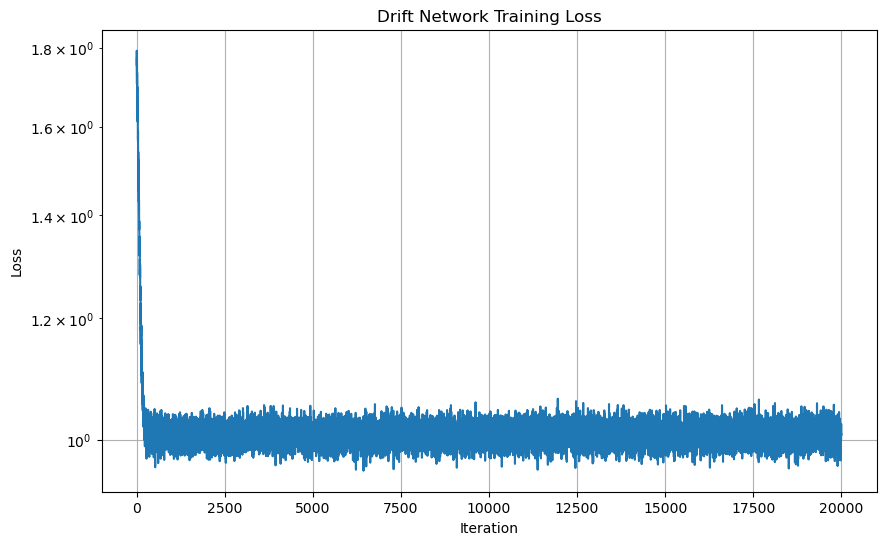


评估漂移项网络...
Drift relative L2 errors - a1: 8.0159e-01, a2: 5.3755e-01, total: 6.7400e-01


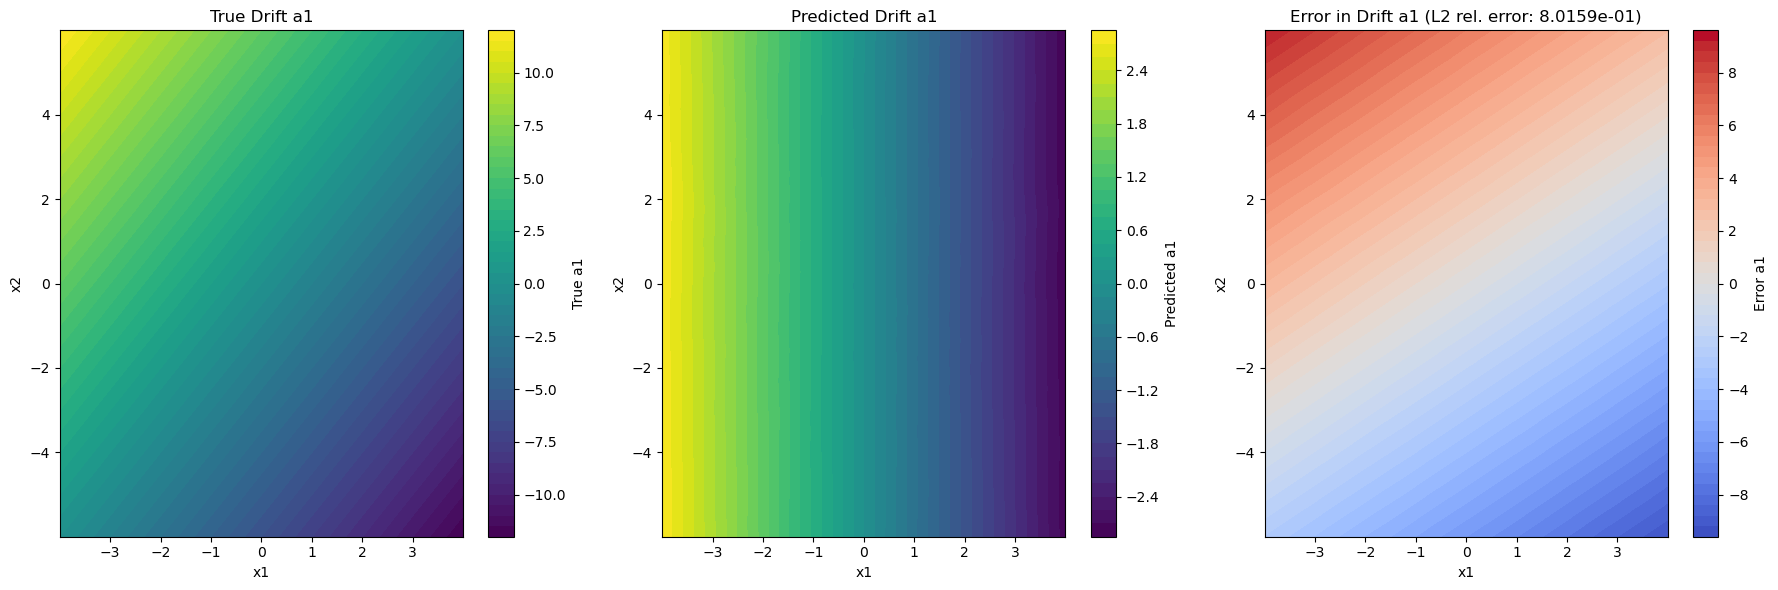

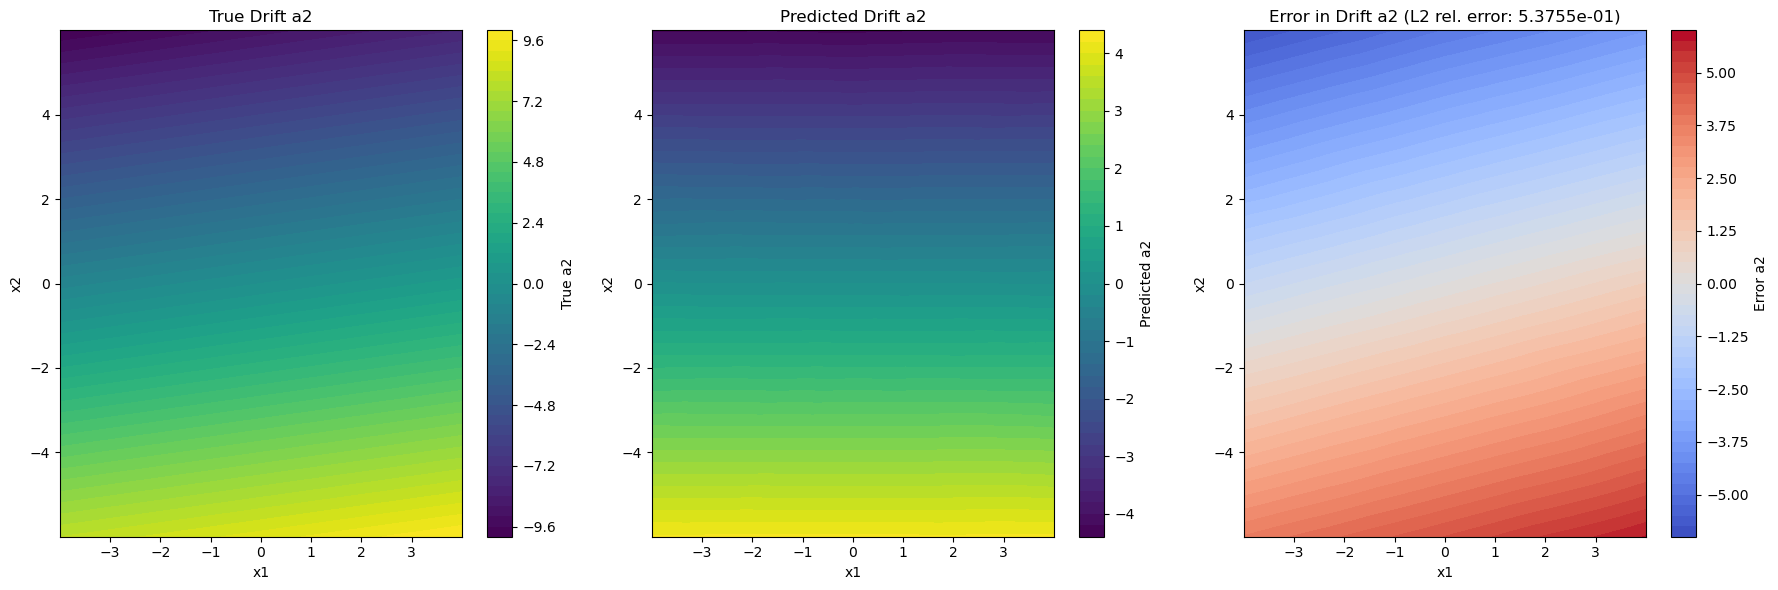

漂移项网络相对L2误差: 6.7400e-01


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from scipy.special import roots_legendre

# 设置随机种子以确保可复现性
# torch.manual_seed(42)
# np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def phi(x):
    x1, x2 = x[:, 0], x[:, 1]
    return 1 + (2/15) * (4 * x1**2 - x1 * x2 + x2**2)

# 定义漂移 a(x)
def drift(x):
    x1, x2 = x[:, 0], x[:, 1]
    a1 = -1.5 * x1 + x2
    a2 = 0.25 * x1 - 1.5 * x2
    return torch.stack([a1, a2], dim=1)


# 定义扩散 b(x)
def diffusion(x, d, device):
    batch_size = x.shape[0]
    sqrt_phi_val = torch.sqrt(phi(x))
    
    # 创建一个批处理的2x2矩阵
    b_matrix = torch.zeros(batch_size, d, d, device=device)
    
    # 填充矩阵
    b_matrix[:, 0, 0] = sqrt_phi_val
    b_matrix[:, 0, 1] = 0
    b_matrix[:, 1, 0] = -sqrt_phi_val * (11 / 8)
    b_matrix[:, 1, 1] = (torch.sqrt(torch.tensor(255.0, device=device)) / 8) * sqrt_phi_val
    
    return b_matrix

# 使用批处理和GPU加速的Euler-Maruyama方法
def simulate_sde_batched(N, d, batch_size, delta_t, device):
    # 结果数组，存储在CPU上
    x_result = torch.zeros((N, d), dtype=torch.float64)
    x_result[0] = torch.tensor([0.0, 0.0])  # 初始点
    
    # 当前状态，初始为[0,0]
    x_current = torch.zeros((batch_size, d), device=device)
    
    # 使用批处理进行模拟
    for n in tqdm(range(0, N-1, batch_size)):
        # 确定当前批次的实际大小（最后一批可能小于batch_size）
        current_batch_size = min(batch_size, N-1-n)
        
        if current_batch_size < batch_size:
            x_current = x_current[:current_batch_size]
        
        # 漂移项
        drift_term = drift(x_current) * delta_t
        
        # 扩散项
        diffusion_matrices = diffusion(x_current, d, device)  # 形状: [batch_size, d, d]
        noise = torch.randn(current_batch_size, d, device=device)  # 标准正态噪声
        
        # 对每个样本应用扩散矩阵
        diffusion_term = torch.sqrt(torch.tensor(delta_t, device=device)) * torch.bmm(diffusion_matrices, noise.unsqueeze(-1)).squeeze(-1)
        
        # 更新状态
        x_next = x_current + drift_term + diffusion_term
        
        # 将结果转移到CPU并存储
        x_result[n+1:n+1+current_batch_size] = x_next.cpu()
        
        # 更新当前状态为新状态（用于下一个批次）
        if n + batch_size < N - 1:
            x_current = x_next.clone()
        
    return x_result

# 2. 定义神经网络模型
class Mish(nn.Module):
    """Mish激活函数: x * tanh(softplus(x))"""
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x * torch.tanh(torch.nn.functional.softplus(x))

class ReLU3(nn.Module):
    """ReLU3激活函数: min(max(0,x), 3)"""
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return torch.clamp(torch.relu(x), max=3.0)


class ResNet(nn.Module):
    """根据图片描述修改的 ResNet，修复维度不匹配问题"""
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=6, activation='mish'):
        super(ResNet, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_blocks = num_blocks
        
        # 输入映射层：将 input_dim 映射到 hidden_dim
        # self.input_map = nn.Linear(input_dim, hidden_dim)
        
        # 每层的线性变换（只有一个线性层）
        self.layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_blocks)
        ])
        
        # 选择激活函数
        if activation == 'relu':
            self.act = nn.ReLU()
        elif activation == 'mish':
            self.act = Mish()
        elif activation == 'relu3':
            self.act = ReLU3()
        else:
            raise ValueError(f"不支持的激活函数: {activation}")
        
        # 输出层
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        # Kaiming 初始化
        # for layer in self.layers:
        #     nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        #     nn.init.zeros_(layer.bias)
        # nn.init.kaiming_normal_(self.output_layer.weight, mode='fan_out', nonlinearity='relu')
        # nn.init.zeros_(self.output_layer.bias)
    
    def forward(self, x):
        # 将输入映射到 hidden_dim
        # 使用0将x从input_dim填充成hidden_dim
        batch_size = x.shape[0]
        x_mapped = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        x_mapped[:, :x.shape[1]] = x  # 只填充前input_dim个维度，其余为0
        
        # 初始条件：h_0 = x_mapped, h_{-1} = 0
        h = [torch.zeros_like(x_mapped), x_mapped]  # h[-1] = h_{-1}, h[-2] = h_0
        
        # 逐层计算
        for ell in range(self.num_blocks):
            # v_ell = sigma(W_ell * h_{ell-1} + g_ell)
            v_ell = self.act(self.layers[ell](h[-1]))
            # h_ell = pad(h_{ell-2}) + v_ell
            h_ell = h[-2] + v_ell  # h1 = RLx; h2 = x + RLRLx; h3 = RL + RL(x + RLRLx); ...
            h.append(h_ell)
        
        # 最终输出：c^T h_L
        h_L = h[-1]
        return self.output_layer(h_L)



class DriftNet(nn.Module):
    """估计漂移项的网络 - 使用ReLU激活函数"""
    def __init__(self, input_dim=2, hidden_dim=50, output_dim=2, num_blocks=6):
        super(DriftNet, self).__init__()
        self.net = ResNet(input_dim, hidden_dim, output_dim, num_blocks, activation='relu')
    
    def forward(self, x):
        return self.net(x)

# 3. 训练函数

def train_drift_net_from_data(a_nn, x_data, y_data, num_iterations=20000, batch_size=10000, lr=1e-4, device=device):
    """训练漂移项网络 - 使用时间序列数据中的实际位移"""
    print("训练漂移项网络...")
    a_nn.to(device)
    optimizer = optim.Adam(a_nn.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_iterations)
    
    losses = []
    
    
    # 将训练数据预先转移到GPU，减少每次迭代的数据传输开销
    print("将训练数据预加载到GPU...")
    x_data_tensor = torch.tensor(x_data, dtype=torch.float64, device=device)
    y_data_tensor = torch.tensor(y_data, dtype=torch.float64, device=device)
    
    for i in tqdm(range(num_iterations)):
        # 随机抽取批次
        idx = torch.randint(0, len(x_data), (batch_size,), device=device)
        x_batch = x_data_tensor[idx]
        y_batch = y_data_tensor[idx]
        
        # 前向传播
        a_pred = a_nn(x_batch)
        
        # 计算损失
        loss = torch.mean((a_pred - y_batch) ** 2)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(a_nn.parameters(), max_norm=40.0)  # 限制梯度的L2范数不超过40.0
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        
        if (i+1) % 1000 == 0:
            print(f"Iteration {i+1}/{num_iterations}, Loss: {loss.item():.6f}")
    
    return losses

def generate_gauss_quadrature_points(nx=100, ny=100, x_range=(-4, 4), y_range=(-6, 6)):
    """生成二维高斯求积点
    
    参数:
        nx, ny: 每个维度的高斯点数量
        x_range, y_range: 积分区域的范围
    
    返回:
        points: 形状为(nx*ny, 2)的高斯点坐标
        weights: 对应的积分权重，形状为(nx*ny,)
        X, Y: 重构的网格矩阵，用于可视化
    """
    # 获取一维高斯-勒让德点和权重
    x_points, x_weights = roots_legendre(nx)
    y_points, y_weights = roots_legendre(ny)
    
    # 将[-1,1]范围映射到指定范围
    x_min, x_max = x_range
    y_min, y_max = y_range
    
    x_points = 0.5 * (x_max - x_min) * (x_points + 1) + x_min
    y_points = 0.5 * (y_max - y_min) * (y_points + 1) + y_min
    
    # 计算二维点的笛卡尔积
    xx, yy = np.meshgrid(x_points, y_points)
    points = np.column_stack([xx.flatten(), yy.flatten()])
    
    # 计算对应的权重（两个方向权重的张量积）
    xx_weights, yy_weights = np.meshgrid(x_weights, y_weights)
    weights = xx_weights.flatten() * yy_weights.flatten()
    
    # 调整权重，考虑积分区域的大小
    area_factor = 0.25 * (x_max - x_min) * (y_max - y_min)
    weights = weights * area_factor
    
    return points, weights, xx, yy

def compute_relative_L2_error_with_quadrature(func_true, func_pred, grid_points, weights):
    """使用高斯求积计算相对L2误差"""
    true_vals = func_true(grid_points)
    pred_vals = func_pred(grid_points)
    
    # 使用权重计算加权均方误差
    squared_diff = np.sum((true_vals - pred_vals)**2, axis=1)
    error = np.sqrt(np.sum(squared_diff * weights))
    
    # 使用权重计算函数范数
    squared_true = np.sum(true_vals**2, axis=1)
    norm = np.sqrt(np.sum(squared_true * weights))
    
    return error / norm

# 4. 评估函数
def evaluate_drift_net(a_nn, grid_points, X, Y):
    """评估漂移项网络
    
    参数:
        a_nn: 训练好的漂移网络模型
        grid_points: 用于可视化的网格点
        X, Y: 用于重构网格的坐标矩阵
    """
    # 生成用于计算相对L2误差的10,000个高斯求积点
    eval_points, eval_weights, _, _ = generate_gauss_quadrature_points(nx=100, ny=100, x_range=(-4, 4), y_range=(-6, 6))
    
    # 转换为张量
    x_tensor = torch.tensor(grid_points, dtype=torch.float64, device=device)
    eval_tensor = torch.tensor(eval_points, dtype=torch.float64, device=device)

    # 计算真实值和预测值（用于可视化）
    with torch.no_grad():
        # 计算真实漂移值
        a_true = drift(x_tensor).cpu().numpy()
        a_pred = a_nn(x_tensor)
        a_pred = a_pred.cpu().numpy() 
        
        # 为L2误差计算获取评估点的真实值和预测值
        a_true_eval = drift(eval_tensor).cpu().numpy()
        a_pred_eval = a_nn(eval_tensor)
        a_pred_eval = a_pred_eval.cpu().numpy()
        
    
    # 计算相对L2误差
    error_a1 = np.sqrt(np.mean((a_true_eval[:, 0] - a_pred_eval[:, 0])**2)) / np.sqrt(np.mean(a_true_eval[:, 0]**2))
    error_a2 = np.sqrt(np.mean((a_true_eval[:, 1] - a_pred_eval[:, 1])**2)) / np.sqrt(np.mean(a_true_eval[:, 1]**2))
    total_error = np.sqrt(np.mean(np.sum((a_true_eval - a_pred_eval)**2, axis=1))) / np.sqrt(np.mean(np.sum(a_true_eval**2, axis=1)))
    
    print(f"Drift relative L2 errors - a1: {error_a1:.4e}, a2: {error_a2:.4e}, total: {total_error:.4e}")
    
    # 绘制结果
    plt.figure(figsize=(18, 6))
    
    # 第一个分量
    plt.subplot(131)
    plt.contourf(X, Y, a_true[:, 0].reshape(X.shape), 50, cmap='viridis')
    plt.colorbar(label='True a1')
    plt.title('True Drift a1')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.subplot(132)
    plt.contourf(X, Y, a_pred[:, 0].reshape(X.shape), 50, cmap='viridis')
    plt.colorbar(label='Predicted a1')
    plt.title('Predicted Drift a1')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.subplot(133)
    plt.contourf(X, Y, (a_true[:, 0] - a_pred[:, 0]).reshape(X.shape), 50, cmap='coolwarm')
    plt.colorbar(label='Error a1')
    plt.title(f'Error in Drift a1 (L2 rel. error: {error_a1:.4e})')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.tight_layout()
    plt.savefig('results/drift_a1_comparison.png')
    # plt.close()
    plt.show()
    
    # 第二个分量
    plt.figure(figsize=(18, 6))
    
    plt.subplot(131)
    plt.contourf(X, Y, a_true[:, 1].reshape(X.shape), 50, cmap='viridis')
    plt.colorbar(label='True a2')
    plt.title('True Drift a2')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.subplot(132)
    plt.contourf(X, Y, a_pred[:, 1].reshape(X.shape), 50, cmap='viridis')
    plt.colorbar(label='Predicted a2')
    plt.title('Predicted Drift a2')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.subplot(133)
    plt.contourf(X, Y, (a_true[:, 1] - a_pred[:, 1]).reshape(X.shape), 50, cmap='coolwarm')
    plt.colorbar(label='Error a2')
    plt.title(f'Error in Drift a2 (L2 rel. error: {error_a2:.4e})')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.tight_layout()
    plt.savefig('results/drift_a2_comparison.png')
    # plt.close()
    plt.show()
    
    return total_error

# 5. 主函数
def main():
    print("\n" + "="*50)
    print("复现论文中的Student's t-distribution实验")
    print("="*50 + "\n")
    
    # 创建输出目录
    os.makedirs("results", exist_ok=True)
    
    # 参数设置 - 按照论文要求
    dt = 0.05  # 时间步长
    d = 2   # 维度
    N = 2*10**7  # 数据点数
    hidden_dim = 50  # 隐藏层维度
    num_blocks = 6   # 残差网络块数量（6层隐藏层）
    data_batch_size = 10000  # 数据批处理大小
    # 训练参数 - 根据论文设置
    num_iterations = 20000  # 训练迭代次数
    drift_batch_size = 10000      # 漂移项批处理大小
    num_trajectories = 1000
    
    # 学习率 - 根据论文设置
    drift_lr = 1e-4        # 漂移项学习率
    # 定义数据范围
    omega_bounds = ([-4, 4], [-6, 6])  # x1, x2的边界


    
    # 1. 数据生成
    print("生成数据...")
    x = simulate_sde_batched(N, d, data_batch_size, dt, device)
    data = x.numpy()

    # data_file = "results/sde_data_oneT.npy"
    # print(f"加载已有数据: {data_file}...")
    # data = np.load(data_file)
        

    # 数据筛选和预处理
    print("筛选和预处理数据...")
    # 首先筛选出在指定范围内的点
    mask_x1 = (data[:, 0] >= omega_bounds[0][0]) & (data[:, 0] <= omega_bounds[0][1]) 
    mask_x2 = (data[:, 1] >= omega_bounds[1][0]) & (data[:, 1] <= omega_bounds[1][1])
    mask = mask_x1 & mask_x2
    filtered_data = data[mask]
    
    # 准备输入和目标数据
    N_filtered = len(filtered_data)
    print(f"筛选后的数据点数量: {N_filtered}")
    
    # 使用CUDA加速计算位移
    print("使用CUDA计算位移...")
    # 将数据转移到GPU
    filtered_data_tensor = torch.tensor(filtered_data, dtype=torch.float64, device=device)
    
    # 使用张量操作计算位移 y = (x_{n+1} - x_n)/dt
    x_data_tensor = filtered_data_tensor[:-1]  # 输入是前N-1个点
    y_data_tensor = (filtered_data_tensor[1:] - filtered_data_tensor[:-1]) / dt
    
    # 转回CPU进行后续处理
    x_data = x_data_tensor.cpu().numpy()
    y_data = y_data_tensor.cpu().numpy()

    x_std = x_data.std(axis=0)
    y_std = y_data.std(axis=0)
    y_data = y_data * x_std / y_std
    
    # 显示数据统计信息
    print(f"筛选后数据点数量: {x_data.shape[0]} ({x_data.shape[0]/len(data)*100:.2f}%)")
    # 检查 y_data 的数值范围
    print(f"筛选后数据统计: min={x_data.min(axis=0)}, max={x_data.max(axis=0)}, mean={x_data.mean(axis=0)}, std={x_data.std(axis=0)}")
    print(f"位移数据统计: min={y_data.min(axis=0)}, max={y_data.max(axis=0)}, mean={y_data.mean(axis=0)}, std={y_data.std(axis=0)}")
    

    # 生成用于可视化的网格点
    print("生成网格点用于可视化和评估...")
    vis_grid_points, vis_weights, X, Y = generate_gauss_quadrature_points(nx=100, ny=100, x_range=(-4, 4), y_range=(-6, 6))

    # 初始化漂移网络
    drift_net = DriftNet(input_dim=2, hidden_dim=hidden_dim, output_dim=2, num_blocks=num_blocks).to(device)
    
    # 训练和评估模型
    print("\n" + "-"*30)
    print("第一步: 训练漂移项网络")
    print("-"*30)
    drift_losses = train_drift_net_from_data(
        drift_net, 
        x_data,
        y_data,
        num_iterations=num_iterations, 
        batch_size=drift_batch_size, 
        lr=drift_lr
    )
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(drift_losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Drift Network Training Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.savefig('results/drift_training_loss.png')
    # plt.close()
    plt.show()
    
    # 评估漂移项网络
    print("\n评估漂移项网络...")
    drift_error = evaluate_drift_net(drift_net, vis_grid_points, X, Y)
    print(f"漂移项网络相对L2误差: {drift_error:.4e}")

# 执行主函数
if __name__ == "__main__":
    main()